# STEP 2: NLP Pre-processing

### 2.1 Import Necessary libraries 


In [ ]:
import pandas as pd  
import numpy as np 
import nltk 
import spacy # spacy is excellent for more advanced NLP tasks 
import re # regular epxressions 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from bs4 import BeautifulStoneSoup   

#for visualisations that might be the part of text EDA 
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter 
from wordcloud import WordCloud 

# other  utilities 
import os  
import warnings 


### 2.2 Configure Settings 

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 80)
sns.set_style('whitegrid')
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4') 
try:
    nlp_spacy = spacy.load('en_core_web_sm')
    print("spaCy 'en_core_web_sm' model loaded successfully.")
except OSError:
    print("spaCy 'en_core_web_sm' model not found. Please run: `python -m spacy download en_core_web_sm`")
    nlp_spacy = None 

print("Libraries imported and settings configured for NLP Preprocessing.")


[nltk_data] Downloading package punkt to /Users/ramesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/ramesh/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/ramesh/nltk_data...


spaCy 'en_core_web_sm' model loaded successfully.
Libraries imported and settings configured for NLP Preprocessing.


### 2.3 Load Processed Data 

In [3]:
DATA_DIR = '../data/'
PROCESSED_DATA_FILE = os.path.join(DATA_DIR, 'reviews_nlp_ready_step1.csv')

def load_processed_data(file_path):
    try: 
        df = pd.read_csv(file_path) 
        print(f'Processed data loaded successfully from {file_path}. Shape: {df.shape}')
        #ensure text columns are still treated as strings, especially if NaNs were introduced/mishandled
        if 'Review Text' in df.columns: 
            df['Review Text']= df['Review Text'].astype(str).fillna('')
        if 'Title' in df.columns: 
            df['Title'] =df['Title'].astype(str).fillna('')
        return df  
    except FileNotFoundError: 
        print(f'Error: Fine not found at {file_path}')
        return None 
    except Exception as e: 
        print(f'An Error occurred: {e}')
        

In [4]:
df_nlp   = load_processed_data(PROCESSED_DATA_FILE)
if df_nlp is not None: 
    print('\n --- First 5 Rows of Loaded df_nlp ---')
    print(df_nlp.head())    
    print('\n --- Info for df_nlp ---')
    df_nlp.info()
else: 
    print('Data loading failed. Cannot proceed.') 

TEXT_COLUMN_TO_PROCESS ='Review Text' # we'll use this for now

Processed data loaded successfully from ../data/reviews_nlp_ready_step1.csv. Shape: (23465, 10)

 --- First 5 Rows of Loaded df_nlp ---
   Clothing ID  Age                    Title  \
0          767   33                      nan   
1         1080   34                      nan   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                                                       Review Text  \
0                            Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i...   
2  I had such high hopes for this dress and really wanted it to work for me. i ...   
3  I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time...   
4  This shirt is very flattering to all due to the adjustable front tie. it is ...   

   Rating  Recommended IND  Positive Feedback Count   Divi

In [6]:
import spacy
from collections import Counter

# Load the English model
nlp = spacy.load("en_core_web_sm")

# Check if df_nlp and the target column exist
if df_nlp is not None and TEXT_COLUMN_TO_PROCESS in df_nlp.columns:
    
    # Flatten all review texts into a single list of lowercased words (excluding spaces)
    all_words_before_cleaning = [
        token.text.lower()
        for text in df_nlp[TEXT_COLUMN_TO_PROCESS].dropna()
        for token in nlp(str(text))
        if not token.is_space
    ]
    
    # Count word frequencies
    word_counts_before_cleaning = Counter(all_words_before_cleaning)
    
    # Display top 20 most common words
    print("\n--- Top 20 Most Common Words (Before Extensive Cleaning) ---")
    print(word_counts_before_cleaning.most_common(20))

else:
    print("Dataframe is None or the specified column does not exist.")


--- Top 20 Most Common Words (Before Extensive Cleaning) ---
[('.', 89911), ('the', 76098), ('i', 66938), ('it', 49164), ('and', 48962), (',', 48050), ('a', 42990), ('is', 31148), ('this', 25739), ('to', 24580), ('in', 20746), ('but', 16547), ('on', 15312), ('!', 14412), ('for', 13994), ('of', 13428), ('was', 12938), ('with', 12800), ('so', 12014), ('my', 11022)]


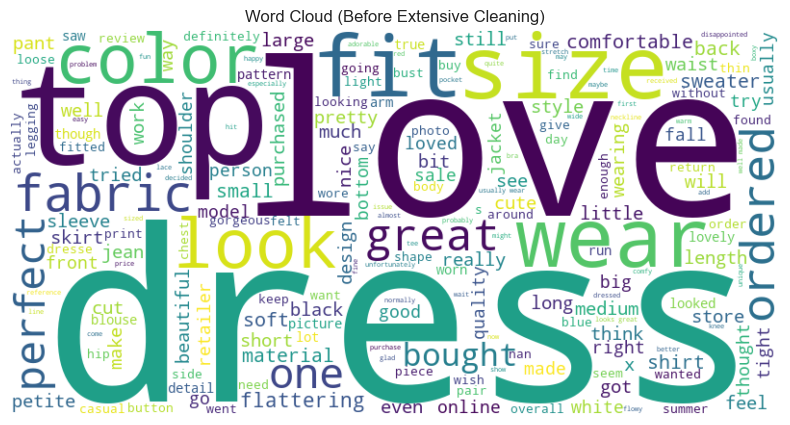

In [7]:

# Make sure df_nlp and the text column exist
if df_nlp is not None and TEXT_COLUMN_TO_PROCESS in df_nlp.columns:
    
    # Filter out empty or NaN entries, join them into a single string
    text_for_wordcloud = " ".join(
        review for review in df_nlp[TEXT_COLUMN_TO_PROCESS].dropna()
        if isinstance(review, str) and len(review.strip()) > 0
    )

    if text_for_wordcloud.strip():
        # Generate the word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white'
        ).generate(text_for_wordcloud)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud (Before Extensive Cleaning)')
        plt.show()
    else:
        print("Not enough valid text content to generate a word cloud.")
else:
    print("DataFrame is None or the specified column does not exist.")

### 2.5 Defining NLP PreProcessing functions  

In [8]:
stop_words  = set(stopwords.words('english'))

#Function 1: Basic text clearning (lowercase, remove punctuation, numbers etc.) 
def clean_text_basic(text): 
    if not isinstance(text,str):
        text= str(text)
    text = text.lower() 
    text = re.sub(r'<.*?>','', text)# remove html tags if any 
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'https://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove numbers/digits
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = text.strip() # Remove leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
    return text


In [12]:
def lemmatize_and_remove_stopwords(text, spacy_model=nlp_spacy, stop_words_set=stop_words):
    if spacy_model is None:
        # Fallback or error if spaCy model isn't loaded
        print("spaCy model not loaded. Lemmatization will be skipped or use NLTK fallback.")
        # Basic tokenization and stopword removal without lemmatization if spaCy fails
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words_set and len(word) > 1]
        return filtered_tokens
        
    doc = spacy_model(text)
    # Lemmatize, remove stopwords, punctuation, and ensure words are alphabetic and longer than 1 char
    lemmatized_tokens = [
        token.lemma_.lower() for token in doc 
        if token.is_alpha and          # Keep only alphabetic tokens
           not token.is_stop and       # Remove spaCy's default stopwords (can also use our nltk stop_words_set)
           token.lemma_.lower() not in stop_words_set and # Ensure our custom NLTK stopwords are also removed
           len(token.lemma_) > 1       # Remove single-character tokens (often noise)
    ]
    return lemmatized_tokens


In [13]:
# --- Let's test these functions on a sample review ---
if df_nlp is not None and not df_nlp.empty:
    sample_text = df_nlp[TEXT_COLUMN_TO_PROCESS].iloc[0]
    print(f"\n--- Original Sample Text ---\n{sample_text}")
    
    cleaned_sample = clean_text_basic(sample_text)
    print(f"\n--- Basic Cleaned Sample Text ---\n{cleaned_sample}")
    
    if cleaned_sample: # Ensure there's text to lemmatize
        lemmatized_sample_tokens = lemmatize_and_remove_stopwords(cleaned_sample)
        print(f"\n--- Lemmatized & Stopwords Removed Sample Tokens ---\n{lemmatized_sample_tokens}")
    else:
        print("\nSample text was empty after basic cleaning, skipping lemmatization test.")
else:
    print("df_nlp is not available or empty, skipping function tests.")



--- Original Sample Text ---
Absolutely wonderful - silky and sexy and comfortable

--- Basic Cleaned Sample Text ---
absolutely wonderful silky and sexy and comfortable

--- Lemmatized & Stopwords Removed Sample Tokens ---
['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable']


In [16]:
# 2.6 Apply preprocessing to the DataFrame 
if df_nlp is not None:
    print("\nStarting NLP preprocessing on the dataset...")
    
    # Step 1: Apply basic text cleaning
    # Create a new column for the initially cleaned text
    df_nlp['cleaned_text_basic'] = df_nlp[TEXT_COLUMN_TO_PROCESS].apply(clean_text_basic)
    print("Basic text cleaning applied.")

    # Step 2: Apply lemmatization and stop word removal
    # This will result in a list of tokens for each review
    # This can take some time on a large dataset
    df_nlp['processed_tokens'] = df_nlp['cleaned_text_basic'].apply(lemmatize_and_remove_stopwords)
    print("Lemmatization and stop word removal applied.")

    print("\n--- First 5 Rows with Processed Tokens ---")
    print(df_nlp[[TEXT_COLUMN_TO_PROCESS, 'processed_tokens']].head())

    # Optional: Create a column with processed text joined back into a string (useful for some vectorizers or quick inspection)
    df_nlp['processed_text_joined'] = df_nlp['processed_tokens'].apply(lambda tokens: ' '.join(tokens))
    print("\n--- First 5 Rows with Joined Processed Text ---")
    print(df_nlp[[TEXT_COLUMN_TO_PROCESS, 'processed_text_joined']].head())
    
    print("\nPreprocessing complete.")
else:
    print("df_nlp is not available. Skipping preprocessing application.")





Starting NLP preprocessing on the dataset...
Basic text cleaning applied.
Lemmatization and stop word removal applied.

--- First 5 Rows with Processed Tokens ---
                                                                       Review Text  \
0                            Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i...   
2  I had such high hopes for this dress and really wanted it to work for me. i ...   
3  I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time...   
4  This shirt is very flattering to all due to the adjustable front tie. it is ...   

                                                                  processed_tokens  
0                                [absolutely, wonderful, silky, sexy, comfortable]  
1  [love, dress, sooo, pretty, happen, find, store, glad, bc, order, online, bc...  
2  [high, hope, dress, want, work, initially, order, petite, sma

### 2.7 Quick EDA on Processed TEXT


 --- Top 20 Most Common Words (After Preprocessing.)---
[('dress', 11983), ('fit', 10750), ('love', 10281), ('size', 10210), ('wear', 10063), ('look', 9206), ('like', 7589), ('color', 6998), ('great', 6085), ('small', 5254), ('order', 4972), ('fabric', 4844), ('buy', 4137), ('little', 3771), ('perfect', 3732), ('try', 3620), ('soft', 3408), ('think', 3404), ('large', 3352), ('long', 3217)]


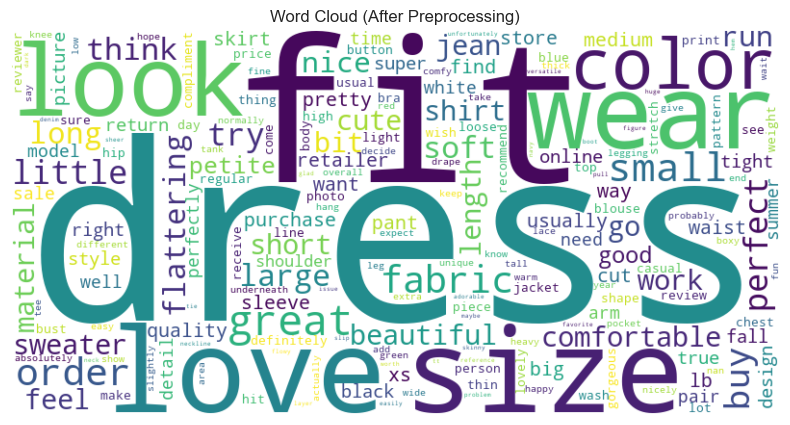

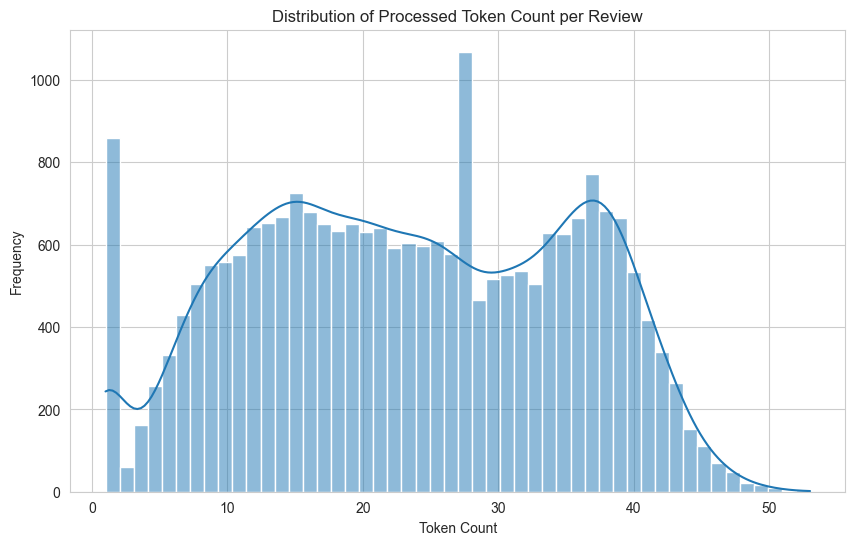


--- Descriptive Stats for Processed Token Counts ---
count    23465.000000
mean        23.355338
std         11.691619
min          1.000000
25%         14.000000
50%         23.000000
75%         34.000000
max         53.000000
Name: processed_token_count, dtype: float64

Number of reviews with 0 tokens after processing: 0 (out of 23465)


In [17]:
if df_nlp is not None and 'processed_tokens' in df_nlp.columns: 
    #flatten all processed tokens into a single list 
    all_processed_words = [word for tokens_list in df_nlp['processed_tokens'] for word in tokens_list]

    if all_processed_words: #check if the list is not empty
        processed_word_counts = Counter(all_processed_words)
        print('\n --- Top 20 Most Common Words (After Preprocessing.)---')
        print(processed_word_counts.most_common(20))
        #word cloud after processing 
        text_for_processed_wordcloud = " ".join(all_processed_words)
        if text_for_processed_wordcloud.strip(): #ensure there's content 
            wordcloud_processed = WordCloud(width=800, height =400, background_color='white',collocations =False).generate(text_for_processed_wordcloud)
            #collocations =False precents it from tryting to find bigrams which can be good for single word clouds
            plt.figure(figsize= (10,5))
            plt.imshow(wordcloud_processed,interpolation= 'bilinear')
            plt.axis('off')
            plt.title('Word Cloud (After Preprocessing)')
            plt.show()
        else: 
            print('Not enough text content to generate a processed word cloud.')
    else: 
        print('No processed words found to perform EDA on.')

#distribution of review lengths (number of tokens) after preprocessing 
df_nlp['processed_token_count'] = df_nlp['processed_tokens'].apply(len)
plt.figure(figsize= (10,6))
sns.histplot(df_nlp['processed_token_count'],bins =50, kde =True)
plt.title('Distribution of Processed Token Count per Review')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()  

print("\n--- Descriptive Stats for Processed Token Counts ---")
print(df_nlp['processed_token_count'].describe())
    
    # Check for reviews that became empty after processing
empty_after_processing = df_nlp[df_nlp['processed_token_count'] == 0].shape[0]
print(f"\nNumber of reviews with 0 tokens after processing: {empty_after_processing} (out of {len(df_nlp)})")


In [18]:
try:
    df_nlp.to_csv(os.path.join(DATA_DIR, 'reviews_nlp_processed_step2.csv'), index=False)
    print("\n'df_nlp' with processed text saved to 'reviews_nlp_processed_step2.csv'")
except Exception as e:
    print(f"Error saving DataFrame: {e}")


'df_nlp' with processed text saved to 'reviews_nlp_processed_step2.csv'
